## Colour detection

### 1. Load dataset

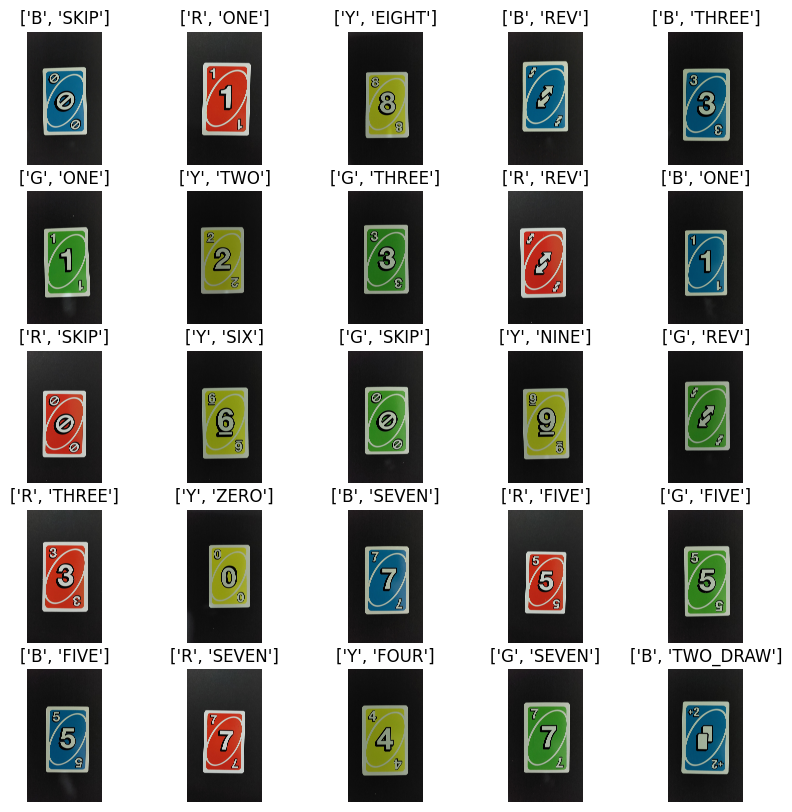

In [2]:
import glob
import cv2 as cv
import os
import matplotlib.pyplot as plt
import numpy as np
import random
# Load dataset
images = []
labels = []

for Dataset_Uno in glob.glob("Main_Dataset/*"): # CARDS is the name of the UNO cards folder.
  # Load image
  img = cv.imread(Dataset_Uno)
  images.append(img)

  # Parse image filename for label
  bname = os.path.basename(Dataset_Uno) # only get filename ( remove directory path )
  rname, _ = os.path.splitext(bname) # remove extension

  # Example names:
  #  * ZERO_B
  #  * TWO_B_DRAW
  #  * SKIP_Y
  # 
  # The second part is the color (R,G,B,Y)
  name_parts = rname.split("_")
  color = name_parts[1]
  label = "_".join([name_parts[0]]+name_parts[2:])

  # Now color is R,G,B,Y
  # label is ZERO, TWO_DRAW, SKIP, ...
  labels.append([color, label])

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  # Last indices is the reverse BGR to RGB
  # Opencv works in BGR, matplotlib need to display in RGB
  plt.imshow(images[i][:,:,::-1])
  plt.axis('off')
  plt.title(str(labels[i]))

### 2. Extracting Card from Image

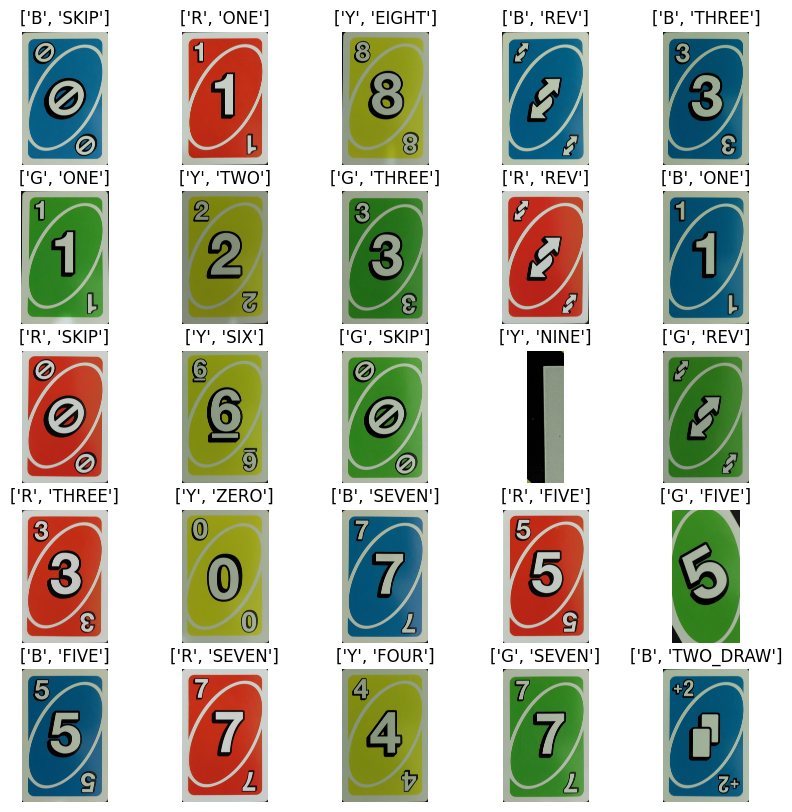

In [3]:
# Find region of interest (ROI) for each image
for i in range(len(images)):
  # adaptive threshold to find edges
  # Apply a gaussian blur just before to 
  # making sure it doesn't pick noise edges
  gray = cv.cvtColor(images[i], cv.COLOR_BGR2GRAY)
  gray = cv.GaussianBlur(gray, (21, 21), 0)
  th = cv.adaptiveThreshold(gray, 255,
      cv.ADAPTIVE_THRESH_GAUSSIAN_C,
      cv.THRESH_BINARY, 11, 2)

  # Get negative to find contours
  th = 255 - th 

  kernel = np.ones((3, 3), np.uint8)
  th = cv.morphologyEx(th, cv.MORPH_DILATE, kernel, iterations=10)

  # Find biggest external contour which is 
  # quadrilatel like
  contours, hierarchy = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  idx_biggest = np.argmax([cv.contourArea(c) for c in contours])
  idx_inner = hierarchy[0][idx_biggest][2]
  cnt = contours[idx_inner]

  # cv.drawContours(images[i], contours, -1, (0, 0, 255), 2)
  # cv.drawContours(images[i], contours, idx_inner, (0, 0, 255), 2)

  # Find oriented bounding box around card
  rect = cv.minAreaRect(cnt)
  box = cv.boxPoints(rect)

  # Have the most top-left first, and also 
  # the contour should be clockwise from the 
  # previous functions
  idx_leftop = np.argmin([p[0]+p[1] for p in box])
  box_ordered = []
  for j in range(4):
    box_ordered.append(box[(idx_leftop+j)%4])
  box = np.array(box_ordered)

  box_len1 = np.linalg.norm(box[0]-box[1])
  box_len2 = np.linalg.norm(box[2]-box[3])

  box_len3 = np.linalg.norm(box[1]-box[2])
  box_len4 = np.linalg.norm(box[3]-box[0])

  box_l1 = (box_len1+box_len2)/2
  box_l2 = (box_len3+box_len4)/2


  # Card is straight
  new_width, new_height = None, None
  if box_l1 < box_l2:
    new_points = np.array([
      [0, 0], [box_l1, 0], [box_l1, box_l2], [0, box_l2]])
    new_width = box_l1
    new_height = box_l2

  # Card is on its side
  else:
    new_points = np.array([[box_l2, 0], [box_l2, box_l1], [0, box_l1], [0, 0]])
    new_width = box_l2
    new_height = box_l1

  # Compute perspective transform matrix and get wrapped
  # image which is only the card
  M = cv.getPerspectiveTransform(np.float32(box), np.float32(new_points))
  roi = cv.warpPerspective(images[i], M, (round(new_width), round(new_height)))

  images[i] = roi

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(images[i][:,:,::-1])
  plt.axis('off')
  plt.title(str(labels[i]))

### 3. Split the dataset into training and testing

Split the dataset into training and testing. Have used ratio of 80% / 20% 

In [4]:
# Do testing for color
# Take a 80% train and 20% test proporition
indices = list(range(len(images)))
random.shuffle(indices)

train_indices = indices[:int(len(images)*0.8)]
test_indices = indices[int(len(images)*0.8):]

print("TRAIN: ", train_indices)
print("TEST: ", test_indices)

TRAIN:  [21, 32, 19, 43, 6, 35, 33, 25, 8, 28, 39, 29, 16, 45, 38, 48, 47, 0, 5, 36, 37, 18, 1, 10, 7, 17, 30, 13, 2, 22, 15, 11, 42, 4, 27, 24, 50, 3, 31, 34, 9]
TEST:  [26, 49, 40, 12, 23, 20, 41, 14, 46, 44, 51]


### 4. Color detection on training

#### 4.1 Resize image
The resizing is mainly done for speed up. 
K-means which is used
Resize it to have a width of 10.

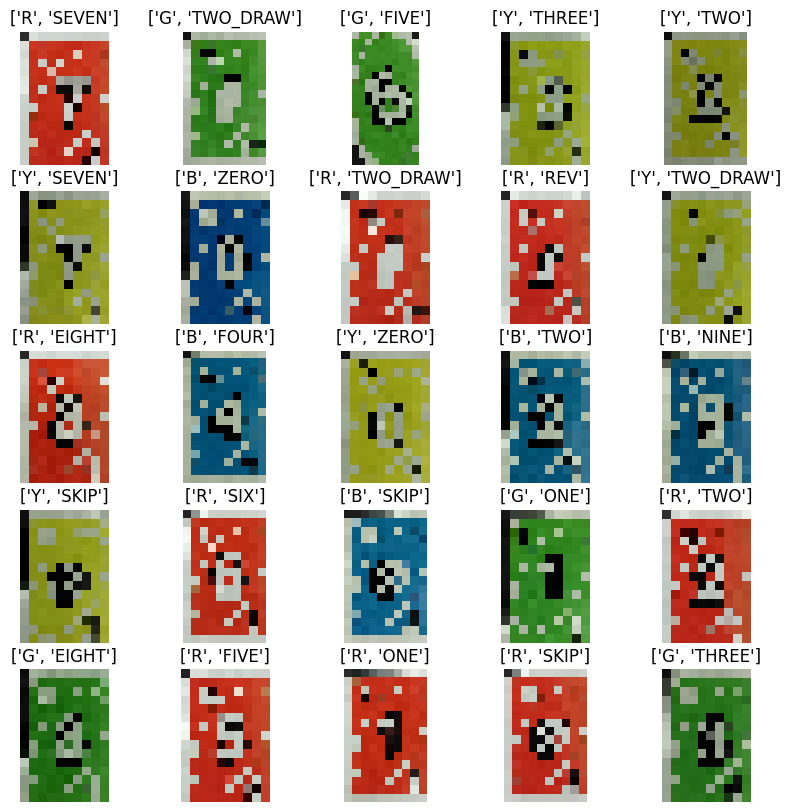

In [5]:
train_images = []

for i in train_indices:
  fxy = 10/images[i].shape[1]
  small = cv.resize(images[i], None, fx=fxy, fy=fxy, interpolation=cv.INTER_NEAREST)
  train_images.append(small)

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(train_images[i][:,:,::-1])
  plt.axis('off')
  plt.title(str(labels[train_indices[i]]))

#### 4.2 Apply k-means 

First the image is reshaped into a single column vector, where each component is the color of a pixel. Then apply k-means to find 2 centers. The images should only have the color white, and the UNO color.

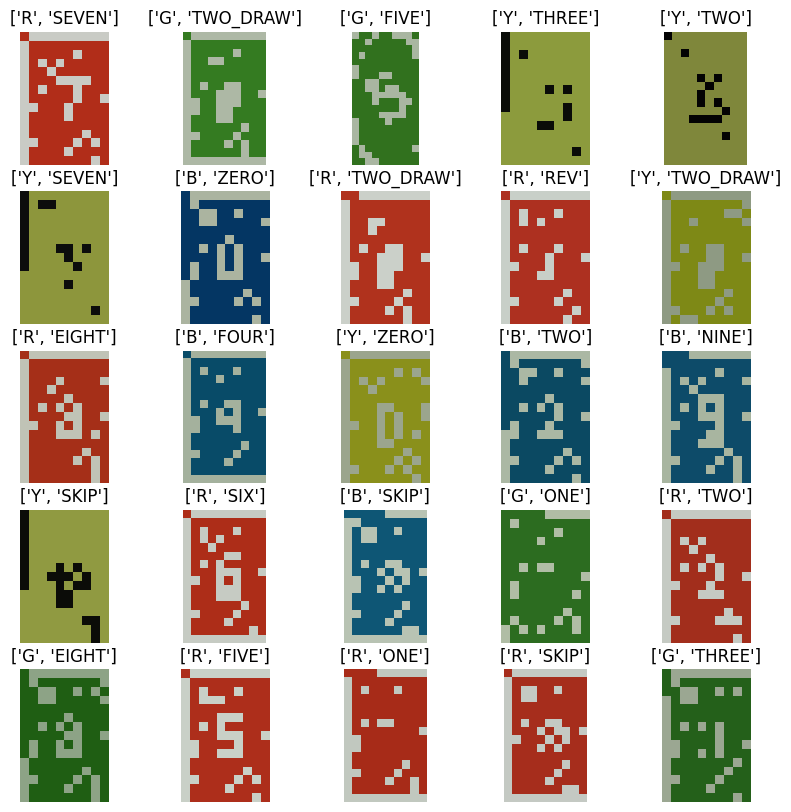

In [6]:
kmeans_result = []
dominant_colors = []

for ii, i in enumerate(train_indices):
  # Apply k-means with k = 2
  Z = train_images[ii].reshape((-1,3))
  Z = np.float32(Z)

  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 2
  ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
  idx_dominant = np.argmax([np.linalg.norm(c - np.array([255, 255, 255])) for c in center])
  dominant_color = center[idx_dominant]
  dominant_colors.append(dominant_color)
  
  center = np.uint8(center)
  res = center[label.flatten()]
  res2 = res.reshape((train_images[ii].shape))

  kmeans_result.append(res2)

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(kmeans_result[i][:,:,::-1])
  plt.axis('off')
  plt.title(str(labels[train_indices[i]]))

#### 4.3 Find hue of dominant color

The color detection has to be robust against light changes. We choose here to pick the hue which is better than picking RGB directly.

In [7]:
for ii, i in enumerate(train_indices):
  dominant_color = cv.cvtColor(dominant_colors[ii][np.newaxis, np.newaxis, :], cv.COLOR_BGR2HSV)
  dominant_color = dominant_color[:,:,0]
  dominant_colors[ii] = dominant_color.flatten()[0]

for ii, i in enumerate(train_indices[:20]):
  print(labels[train_indices[ii]], dominant_colors[ii])

['R', 'SEVEN'] 7.764793
['G', 'TWO_DRAW'] 107.34047
['G', 'FIVE'] 106.40309
['Y', 'THREE'] 91.71429
['Y', 'TWO'] 210.00003
['Y', 'SEVEN'] 91.99999
['B', 'ZERO'] 208.6
['R', 'TWO_DRAW'] 8.721854
['R', 'REV'] 6.535762
['Y', 'TWO_DRAW'] 65.47103
['R', 'EIGHT'] 9.679127
['B', 'FOUR'] 197.99539
['Y', 'ZERO'] 63.075222
['B', 'TWO'] 197.33038
['B', 'NINE'] 199.32236
['Y', 'SKIP'] 77.47572
['R', 'SIX'] 8.469082
['B', 'SKIP'] 198.38065
['G', 'ONE'] 110.48993
['R', 'TWO'] 7.9545293


### 5. Test against testing data

Does the same step as the training data to find the dominant color. Then find the training data which has the closest dominant color and pick its label.

In [8]:
good, bad = 0, 0
for i in test_indices:
  fxy = 10/images[i].shape[1]
  small = cv.resize(images[i], None, fx=fxy, fy=fxy, interpolation=cv.INTER_NEAREST)

  # Apply k-means with k = 2
  Z = small.reshape((-1,3))
  Z = np.float32(Z)

  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 2
  ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)

  idx_dominant = np.argmax([np.linalg.norm(c - np.array([255, 255, 255])) for c in center])
  dominant_color = center[idx_dominant]

  # Convert to HSV and extract hue
  dominant_color = cv.cvtColor(dominant_color[np.newaxis, np.newaxis, :], cv.COLOR_BGR2HSV)
  dominant_color = dominant_color[:,:,0]

  closest_idx = np.argmin([
    np.min([abs(dominant_color - dominant_colors[j]), abs((dominant_color+255) - dominant_colors[j]), abs(dominant_color - (dominant_colors[j]+255))])
    for j in range(len(train_indices))])


  closest_idx = train_indices[closest_idx]

  # Check that color match
  if labels[closest_idx][0] == labels[i][0]:
    good += 1
  else:
    bad += 1


print(f"Color testing: GOOD {good}/BAD {bad}/TOTAL {good+bad}")

Color testing: GOOD 11/BAD 0/TOTAL 11
